In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# for data manipulation
import pandas as pd
import numpy as np
#for data visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
#for interactive plots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.express as px
#import cufflinks as cf
init_notebook_mode(connected=True) #for notebooks
#cf.go_offline() #for offline use


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
df = pd.read_csv("train.csv",index_col = 'date', parse_dates = True)
df_test = pd.read_csv("test.csv",index_col = 'date', parse_dates = True)

The first submission of this notebook scored 7.16 where we didn't exploit any of the findings found by the EDA. 

## 1. Data Exploration 

First, let's explore the data a bit, learn about the columns presented in the Dataset.

In [4]:
df.head()

,row_id,country,store,product,num_sold
date,,,,,
2017-01-01,0,Belgium,KaggleMart,Kaggle Advanced Techniques,663
2017-01-01,1,Belgium,KaggleMart,Kaggle Getting Started,615
2017-01-01,2,Belgium,KaggleMart,Kaggle Recipe Book,480
2017-01-01,3,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
2017-01-01,4,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [5]:
## row_id is of no need to us so let's delete this column
df.drop('row_id',axis=1,inplace=True)
df.isnull().any()

country     False
store       False
product     False
num_sold    False
dtype: bool

One thing about the data is the data of all countires, products and store is presented for each day.

In [6]:
## let's explore the type of columns or features available in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70128 entries, 2017-01-01 to 2020-12-31
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   country   70128 non-null  object
 1   store     70128 non-null  object
 2   product   70128 non-null  object
 3   num_sold  70128 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.7+ MB


Only, the num_sold which is the feature to be forecasted is numeric, rest all are categorical.

First start with the date column and see entries of how many days are present in the date of the dataframe.

In [7]:
print('start:', df.index[0])
print('end:', df.index[-1])
print('days: ', (df.index[-1]-df.index[0]).days)

start: 2017-01-01 00:00:00
end: 2020-12-31 00:00:00
days:  1460


The time frame stretches upon the spon of 1461 days.

Let's explore the country column and see how many unique countries, stores and products are present.

In [8]:
print('unqiue countires:',df['country'].nunique())
print('unqiue stores:',df['store'].nunique())
print('unqiue products:',df['product'].nunique())

unqiue countires: 6
unqiue stores: 2
unqiue products: 4


**So the data seems in manageable scale. Which is the true essence of this competition.**

## 2. Visualizations 

Let's roll our sleeves and see what the data has to tell us about itself.

We will begin first by exploring the trends of the worldwide sells.

In [9]:
df.resample("A").sum().iplot(title="Total sells in each year from 2018 - 2020", xTitle='Years', yTitle='Sell')

AttributeError: 'DataFrame' object has no attribute 'iplot'

**Conclusion**
The sells went up in the year 2018, however again went down for the 2019. In 2020 the sells increased again and following the cyclic trend should we expect 2021 to be lower too? let's not jump to conclusion.

Let's explore the Sell by countries, products and stores

In [ ]:
px.bar(df.groupby('country')['num_sold'].sum(),orientation='h',title = "Total sell by each country")

**Conclusion:** We can see that the Germany has the most number of sell while Poland has the minimum.

In [ ]:
px.bar(df.groupby('product')['num_sold'].sum(),orientation = 'h', title = 'Total sell with respect to the individual product')

**Conclusion:** Kaggle for Kids has been sold the most while the Kaggle Recipe Book was the least popular among the audience.

In [ ]:
px.bar(df.groupby('store')['num_sold'].sum(),orientation = 'h', title = 'Total sell with respect to the individual store')

**Conclusion:** KaggleMart has more business than the KaggleRama

Let's focus our attention to more finer details and see which product was more popular in each store.

In [ ]:
px.bar(df.groupby(['store','product'])['num_sold'].sum().unstack(0),orientation='h')

**Conclusion:** As anticipated, KaggleMart has sold all the books more as compared to KaggleRama. Kaggle for kids is top seller while Kaggle recipe book is least popular.

Let's try to visualize all the country, product and store information in one nice graph.

In [ ]:
dfg = df.groupby(['country','store','product']).sum().reset_index()

In [ ]:
px.bar(dfg,x='num_sold',y='country',color='product',orientation='h',hover_data=['store'], barmode='group', text = 'store',labels={'num_sold':'Total Sell'})

**Conclusion:** Again from this graph it is again clear that the Germany has the highest number of sell. Kaggle for Kids is most sold book in both stores while Kaggle Recepie is the least sold. KaggleMart has most sell in Belgium while KaggleRama has most sell in Germany. Similarly, Both Kaggle for Kids and Kaggle Recepie book has been sold most in Germany while least in Poland.

## 3. Timeseries Visualizations

We have done enough of Visualizations describing the most sold and least sold of each product in each country.

Let's first plot the total sell during the span of whole given data.

In [10]:
df.groupby('date')['num_sold'].sum().iplot(title='Worldwide Sell from year 2017 - 2020')

AttributeError: 'Series' object has no attribute 'iplot'

**Conclusion:** 
* We can infer from the graph that at the end of each year we see a spike near the end of december
* Spikes are also been displayed in the month of April and May. Maybe because of Easter and Labour Day
* By the start of year 2020 till the end of April, we can observe a severe decline in the sell. This was the time when COVID-19 started to hit the world
* From May 2020 the sell start to normalize to its previous values

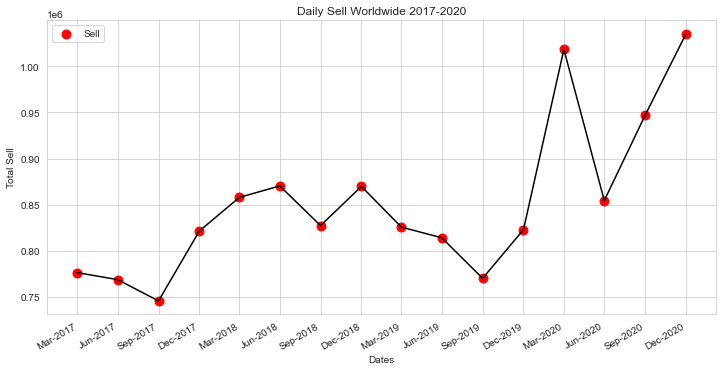

In [11]:
## lets plot yearly data with quarterly pointer to see how the sells wary month to month
## the below plot is inspired by Kaggle User @param302
sns.set_style('whitegrid')
dfm =df.resample('Q').sum()['num_sold']

plt.figure(figsize=(12,6))
plt.title('Daily Sell Worldwide 2017-2020')
plt.xlabel('Dates')
plt.ylabel('Total Sell')
plt.plot(dfm.index,dfm.values,color='black')
plt.scatter(dfm.index,dfm.values,label='Sell',s=80,color='red')
plt.xticks(dfm.index,dfm.index);
plt.gcf().autofmt_xdate()

date_fmt = mdates.DateFormatter("%b-%Y")
plt.gca().xaxis.set_major_formatter(date_fmt)
plt.legend()

**Conclusion:** 
* The Sells increase in the Q4 for every year
* The Sells are usually lower in Q3 however, this trend was not present in case of year 2020
* The Sells in Q2 are showing alternating increase and decrease nature from year 2017 to 2020, shall we expect 2021 Q2 sells be lower?
* The Q1 has the alternating rise and fall too, what to expect for 2021 Q1 sells?

This type of behaviour is hinting us that the instead of 1 year the pattern is repeating after 2 years

Meanwhile Let's also examine how sells are affected monthly and weekly.

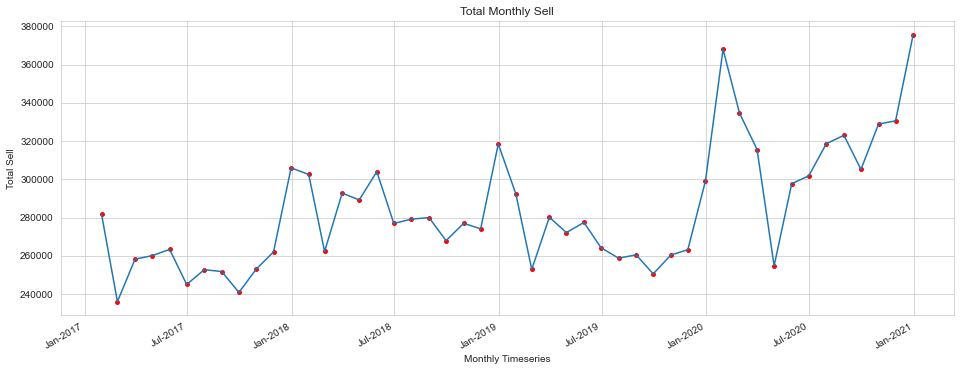

In [12]:
dfc = df.resample('M').sum()
plt.figure(figsize=(16,6))
plt.plot(dfc.index,dfc.num_sold)
plt.scatter(dfc.index,dfc.num_sold,s=15,color='red')
plt.title('Total Monthly Sell')
plt.xlabel('Monthly Timeseries')
plt.ylabel('Total Sell')
plt.gcf().autofmt_xdate()
formater = mdates.DateFormatter("%b-%Y")
plt.gca().xaxis.set_major_formatter(formater)

**Conclusion:** Overall Sell are increasing on the monthly Timeframe

Let's observe the weekly effect by analyzing the sell on each day of the week

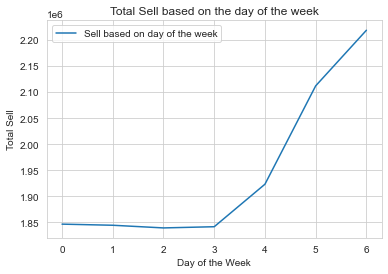

In [13]:
dfc = df.reset_index().copy()
dfc['week_day'] = dfc['date'].apply(lambda x: x.dayofweek)
dfc = dfc.groupby('week_day')['num_sold'].sum()
plt.plot(dfc.index,dfc.values,label='Sell based on day of the week')
plt.title('Total Sell based on the day of the week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sell')
plt.legend();

**Conclusion:** We can verify from the graph that based on the day of the week the total sells are effected

So far we have came across basic plots and visualizations. We can now proceed and try 

Let's plot the complete sell of each country too.

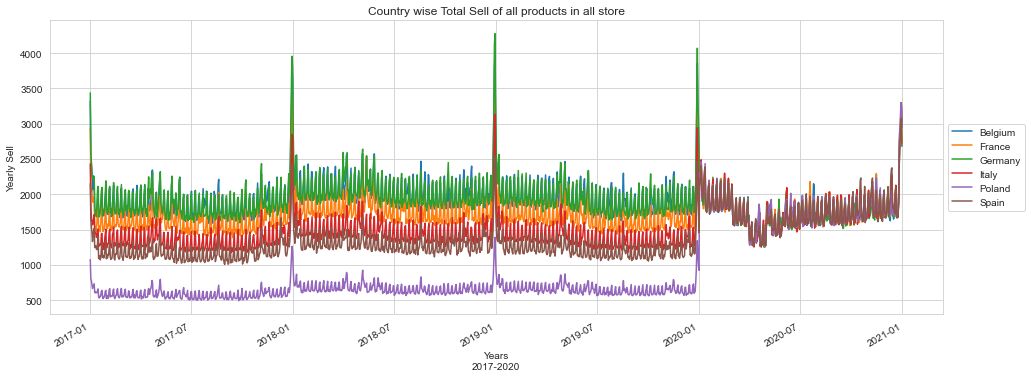

In [14]:
plt.figure(figsize=(16,6))
ax = sns.lineplot(data=df.groupby(['date','country']).sum(), x='date', y='num_sold', hue='country')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.xlabel('Years\n2017-2020')
plt.ylabel('Yearly Sell')
plt.title('Country wise Total Sell of all products in all store');
plt.gcf().autofmt_xdate()

**Conclusion:**
* We can observe that the line for Germany is at the top of the chart while the Poland is at the bottom
* Something Interesting has happened for the year 2020 where the difference between the sell of each country has coalesced

We can verify our hypothesis of sell being coalesced by computing the ratios of the sell for each country.

In [15]:
#this contains daily sells of each product and each store for each year for every country
dfg = df.groupby(['date','country'])['num_sold'].sum().unstack().resample('A').sum() 

##let's create another df where the total sum of each year is present, in order to make the division correct, we will duplicate the columns
dfc = df.resample('A').sum()
for i in range(5):
    dfc['num_sold_'+str(i)] = dfc['num_sold']
    
dfc.columns = dfg.columns
display(dfg/dfc)

country,Belgium,France,Germany,Italy,Poland,Spain
date,,,,,,
2017-12-31,0.218915,0.192268,0.220340,0.160360,0.068738,0.139379
2018-12-31,0.218780,0.191519,0.219516,0.159298,0.071159,0.139728
2019-12-31,0.219105,0.190316,0.218935,0.158532,0.074060,0.139051
2020-12-31,0.166528,0.166696,0.166257,0.167007,0.167162,0.166349


**Conclusion:** We can clearly see that the ratio of sell in each country has become equal to 0.166 in the year 2020. We can make this assumption for the year 2021 too that this pattern continues.

Let's plot the sell of each store too

<AxesSubplot:xlabel='date', ylabel='num_sold'>

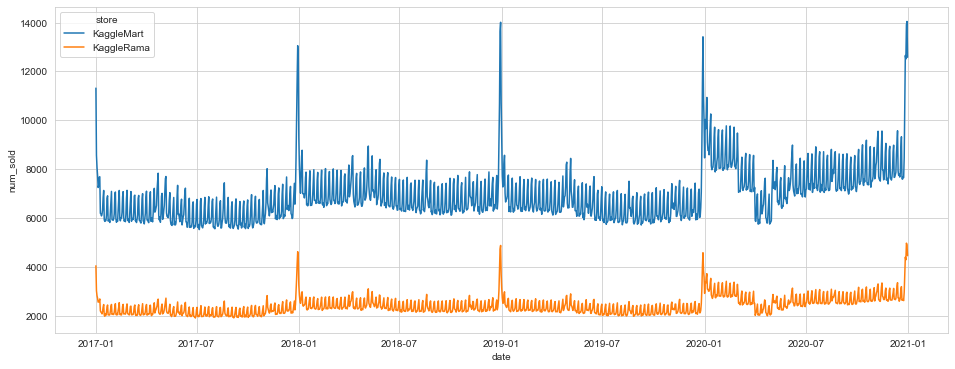

In [16]:
plt.figure(figsize=(16,6))
sns.lineplot(data=df.groupby(['date','store']).sum(), x='date', y='num_sold', hue='store')

The pattern seems almost identical, let's see if we can find the factor by which the KaggleMart sells are higher than KaggleRama

In [17]:
mf = np.mean(df[df['store']=='KaggleMart']['num_sold']/df[df['store']=='KaggleRama']['num_sold'])

print(f'The KaggleMart & KaggleRama sells are the multiplicative Factor of {mf:.3f}')

The KaggleMart & KaggleRama sells are the multiplicative Factor of 2.894


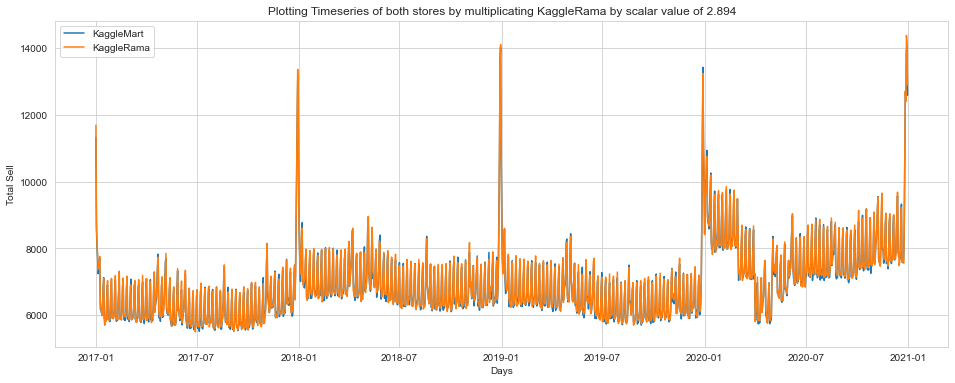

In [18]:
dfc = df.groupby(['store','date']).sum().unstack(0)
dfc.columns = dfc.columns.droplevel()
dfc['KaggleRama'] = dfc['KaggleRama']*2.894

plt.figure(figsize=(16,6))
plt.title('Plotting Timeseries of both stores by multiplicating KaggleRama by scalar value of 2.894')
plt.plot(dfc.index,dfc['KaggleMart'],label='KaggleMart')
plt.plot(dfc.index,dfc['KaggleRama'],label='KaggleRama')
plt.xlabel('Days')
plt.ylabel('Total Sell')
plt.legend()

**Conclusion:** Here the sell of KaggleRama collapsed on the sell of KaggleMart. Both Timeseries are the multiple of each other.

Let's explore the ratio of sells produced by each store too to find any pattern that must be hidden inside the store data.

<AxesSubplot:xlabel='date', ylabel='num_sold'>

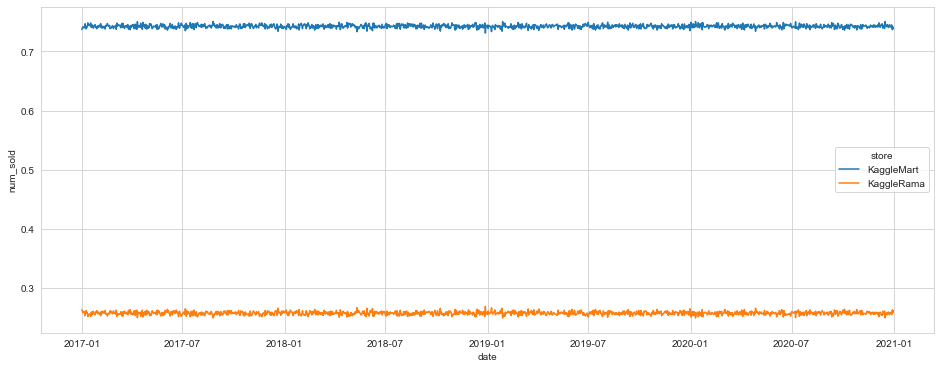

In [19]:
plt.figure(figsize=(16,6))
sns.lineplot(data = (df.groupby(['store','date']).sum()/df.groupby('date').sum()), x='date', y='num_sold', hue='store')

Let's analyze another pattern. This pattern was found by @ehekatlact. If we plot the ratio of sales by product, we find the underlying seasonality pattern.

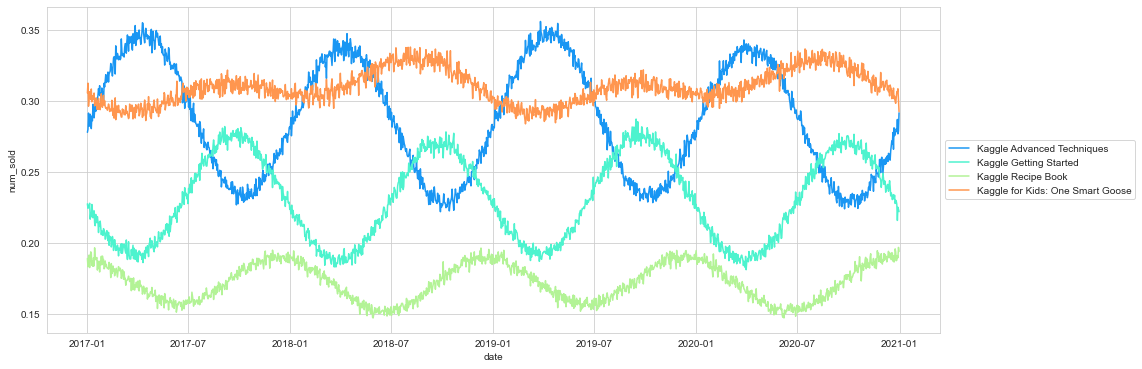

In [20]:
dfc = df.groupby(['product','date']).sum()/df.groupby(['date']).sum()
plt.figure(figsize = (16,6))
ax = sns.lineplot(data=dfc,x='date',y='num_sold',hue='product',palette='rainbow');
ax.legend(loc='center left',bbox_to_anchor=(1,0.5));

**Conclusion:** 
* Here we can observe the perfectly cyclic seasonality in the data
* One thing we can note subtly that the sesonality is for the period of two years as depicted by the orange graph instead of for the one year

As identified by @samuelcortinhas, The given Timeseries are the multiplicative time series where the timeseries seasonality based on the product is multiplied by the timeseries based on the country and store on each given day.

Let's decompose each time series into its given T and P component

We are defining Timeseries as
Y = TxP
where Y is the total sell on each day based on each country, store and product. While, T is the Sell based on each country and store on any given day, and P is the sell by each product on any given day.

In [24]:
dfc

,date,product,P
0,2017-01-01,Kaggle Advanced Techniques,0.277944
1,2017-01-02,Kaggle Advanced Techniques,0.280014
2,2017-01-03,Kaggle Advanced Techniques,0.291529
3,2017-01-04,Kaggle Advanced Techniques,0.282240
4,2017-01-05,Kaggle Advanced Techniques,0.283104
...,...,...,...
5839,2020-12-27,Kaggle for Kids: One Smart Goose,0.306537
5840,2020-12-28,Kaggle for Kids: One Smart Goose,0.306332
5841,2020-12-29,Kaggle for Kids: One Smart Goose,0.308699
5842,2020-12-30,Kaggle for Kids: One Smart Goose,0.300929


In [21]:
dfc = dfc.unstack(0)
dfc.columns = dfc.columns.droplevel()
dfc = dfc.reset_index()
dfc = dfc.melt(id_vars = 'date')
dfc.columns = ['date','product','P']
train = df.reset_index()
train = pd.merge(left=train,right=dfc,on=['date','product'],how='left')

In [22]:
train['T'] = train['num_sold']/train['P']

In [23]:
train

,date,country,store,product,num_sold,P,T
0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663,0.277944,2385.370518
1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615,0.227462,2703.745704
2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480,0.188900,2541.020690
3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710,0.305693,2322.591093
4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240,0.277944,863.482540
...,...,...,...,...,...,...,...
70123,2020-12-31,Spain,KaggleMart,Kaggle for Kids: One Smart Goose,614,0.292525,2098.963067
70124,2020-12-31,Spain,KaggleRama,Kaggle Advanced Techniques,215,0.291703,737.050121
70125,2020-12-31,Spain,KaggleRama,Kaggle Getting Started,158,0.221948,711.877778
70126,2020-12-31,Spain,KaggleRama,Kaggle Recipe Book,135,0.193823,696.511663


We have successfully decomposed the Timeseries into its T and P component.

## 4. Making the model

Till now, we have tried all crazy and advance stuff to make the best model. Let's first set a baseline model without doing anything fancy and from there we will improve the performane.

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [55]:
## copy a dataframe
dfx = df.reset_index()

##adding features
dfx['year'] = dfx['date'].apply(lambda x: int(x.year))
dfx['month'] = dfx['date'].apply(lambda x: int(x.month))
dfx['dayofyear'] = dfx['date'].apply(lambda x: int(x.dayofyear))
dfx['dayofweek'] = dfx['date'].apply(lambda x: int(x.dayofweek))
dfx['week'] = dfx['date'].apply(lambda x: int(x.week))
dfx['quarter'] = dfx['date'].apply(lambda x: int(x.quarter))
cols = list(dfx.columns)
cols.remove("num_sold")
cols.append("num_sold")
dfx = dfx[cols[1:]]

We have added too many features to our dataframe, let's explore the correlations to use only the most useful features.

<AxesSubplot:>

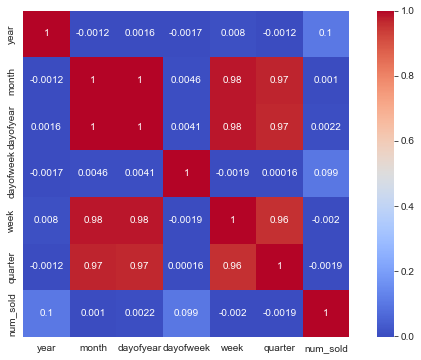

In [56]:
plt.figure(figsize=(10,6))
sns.heatmap(dfx.corr(),square=True, annot=True,cmap='coolwarm')

**Conclusion:** Here we can infer that the all numeric features have the positive correlation with the num_sold instead of week and quarter. We can eliminate these columns as they are not either highly correlated.

In [57]:
cols = [col for col in cols if not col in ['week','quarter']]
dfx = dfx[cols[1:]]

Now it is time for train test split and trying out models to see which one work best.

We will try linear regression first and evaluate its performance and then move towards more advance variants.

In [58]:
cat_cols = ['country','product','store']
## let's do one hot encoding
dfx = dfx.join(pd.get_dummies(dfx[cat_cols],drop_first=True))
dfx.drop(columns=cat_cols, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(dfx.drop('num_sold',axis=1),dfx['num_sold'],test_size=0.2,random_state=42)
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

LinearRegression()

In [59]:
def produce_metric(test_data,true,model):
    pred = model.predict(test_data)
    print("The model has the mean absolute error equal to", mean_absolute_error(true,pred))
    print("The model has the mean squared error equal to", mean_squared_error(true,pred))

In [60]:
produce_metric(X_test,y_test,lin_reg)

The model has the mean absolute error equal to 42.35886937137739
The model has the mean squared error equal to 3246.7650313758722


Let's see if we can improve the predictions by introducting the more advance models.

In [61]:
tree_reg = RandomForestRegressor()
tree_reg.fit(X_train,y_train)
produce_metric(X_test, y_test, tree_reg)

The model has the mean absolute error equal to 9.812128903464993
The model has the mean squared error equal to 226.5161412377014


This model is significantly better than the previous model.

Let's try XGBoost as one last model before incorporating the information regarding the data that we extracted through the EDA

In [62]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',eval_metric= 'rmsle', early_stopping_rounds = 10,use_label_encoder=False)
xgb_model.fit(X_train,y_train,verbose=False,eval_set=[(X_test,y_test)])

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=10, enable_categorical=False,
             eval_metric='rmsle', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [63]:
produce_metric(X_test, y_test, xgb_model)

The model has the mean absolute error equal to 9.175306665732485
The model has the mean squared error equal to 194.09762382433095


The XGBoost prediction is the best one so far, let's use this and make our first sample submission.

In [64]:
test = pd.read_csv("test.csv",index_col = 'date', parse_dates = True).reset_index()

In [65]:
test['year'] = test['date'].apply(lambda x: x.year)
test['month'] = test['date'].apply(lambda x: x.month)
test['dayofyear'] = test['date'].apply(lambda x: x.dayofyear)
test['dayofweek'] = test['date'].apply(lambda x: x.dayofweek)
cols = list(test.columns)
test = test[cols[2:]]

In [66]:
test

,country,store,product,year,month,dayofyear,dayofweek
0,Belgium,KaggleMart,Kaggle Advanced Techniques,2021,1,1,4
1,Belgium,KaggleMart,Kaggle Getting Started,2021,1,1,4
2,Belgium,KaggleMart,Kaggle Recipe Book,2021,1,1,4
3,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,2021,1,1,4
4,Belgium,KaggleRama,Kaggle Advanced Techniques,2021,1,1,4
...,...,...,...,...,...,...,...
17515,Spain,KaggleMart,Kaggle for Kids: One Smart Goose,2021,12,365,4
17516,Spain,KaggleRama,Kaggle Advanced Techniques,2021,12,365,4
17517,Spain,KaggleRama,Kaggle Getting Started,2021,12,365,4
17518,Spain,KaggleRama,Kaggle Recipe Book,2021,12,365,4


In [67]:
test = test.join(pd.get_dummies(test[cat_cols],drop_first=True))
test.drop(columns=cat_cols,inplace=True)
preds = xgb_model.predict(test)

In [68]:
samp = pd.read_csv("sample_submission.csv")
samp['num_sold'] = preds
samp.to_csv("./submission_1.csv", index=False)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/tabular-playground-series-sep-2022/sample_submission.csv'

## 5. Exploiting EDA information

So far we have made a simple model which did not perform too great. Let's try to incorporate all of our findings that we found through EDA and make a new model.

Here our goal will be to uncover the hidden pattern that must be present between the features and let's see if we can eliminate or combine the information of these features.

So far we have found that the sells of KaggleMart is just the multiple of sell of KaggleRama. The time series of pattern of the product is independent of each feature. Also, the total sell for each country is just 16% of the total yearly sell in 2020. We can continue with this assumption and assume that the sell will remain 16% throughout the year 2021 too.

Let's repeat all those steps for just the sell of KaggleRama

In [ ]:
#let's remove KaggleMArt first as it will be produced by multiplying with the sell of KaggleRama
# train = df[df['store'] == 'KaggleRama']
train = df.copy()

In [ ]:
#this contains daily sells of each product and each store for each year for every country
dfg = train.groupby(['date','country'])['num_sold'].sum().unstack().resample('A').sum() 

##let's create another df where the total sum of each year is present, in order to make the division correct, we will duplicate the columns
dfc = pd.DataFrame(train.resample('A').sum()['num_sold'],columns=['num_sold'])
for i in range(5):
    dfc['num_sold_'+str(i)] = dfc['num_sold']
    
dfc.columns = dfg.columns
display((dfg/dfc))

In [ ]:
dfc = train.groupby(['product','date']).sum()/train.groupby(['date']).sum()
dfc = dfc.unstack(0)
dfc.columns = dfc.columns.droplevel()
dfc = dfc.reset_index()
dfc = dfc.melt(id_vars = 'date')
dfc.columns = ['date','product','P']
train = train.reset_index()
train = pd.merge(left=train,right=dfc,on=['date','product'],how='left')
train['T'] = train['num_sold']/train['P']

Our TimeSeries is now decomposed, We now have to aggregate daily sells from each country and each product and make AR model on it. Next, We will distribute these sells equally to all countries and mulitply it with the product ratio of that day.

Firstly, We have to model the seasonality or the P column of our timeseries. This will be done by Fast Fourier Transform. For taking the FFT, we are going to use the code presented by [@Xylambda](https://gist.github.com/Xylambda/b8f38dce74dd3d54ff906eebfe560ac0). Firstly we are going to denoise our sequence to obtain the dominant signal. Once denoised we are going to repeat the pattern as the function is periodic.

In [69]:
def fft_denoiser(x, n_components, to_real=True):
    """Fast fourier transform denoiser.
    
    Denoises data using the fast fourier transform.
    
    Parameters
    ----------
    x : numpy.array
        The data to denoise.
    n_components : int
        The value above which the coefficients will be kept.
    to_real : bool, optional, default: True
        Whether to remove the complex part (True) or not (False)
        
    Returns
    -------
    clean_data : numpy.array
        The denoised data.
        
    References
    ----------
    .. [1] Steve Brunton - Denoising Data with FFT[Python]
       https://www.youtube.com/watch?v=s2K1JfNR7Sc&ab_channel=SteveBrunton
    
    """
    n = len(x)
    
    # compute the fft
    fft = np.fft.fft(x, n)
    
    # compute power spectrum density
    # squared magnitud of each fft coefficient
    PSD = fft * np.conj(fft) / n
    
    # keep high frequencies
    _mask = PSD > n_components
    fft = _mask * fft
    
    # inverse fourier transform
    clean_data = np.fft.ifft(fft)
    
    if to_real:
        clean_data = clean_data.real
    
    return clean_data

In [70]:
prod_series = train.groupby(['date','product']).mean()['P'].unstack()

In [71]:
def model_product_seasonality(product,prod_series=prod_series):
    ser = prod_series[product]
    clean_ser = fft_denoiser(ser,0.04)
    ph = np.zeros(365*5+1) ## +1 reflects the 2020 being leap year
    ph[:365*4+1] = clean_ser
    ph[365*4+1:] = clean_ser[:365]
    return ph[365*4+1:]

Let's make one final plot to know how detrended series look like.

<AxesSubplot:title={'center':'Total Sells Worldwide Detranded'}, xlabel='date'>

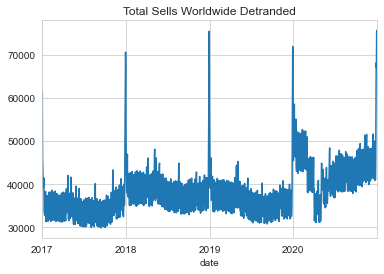

In [72]:
train.groupby('date')['T'].sum().plot(title = "Total Sells Worldwide Detranded")

In [73]:
data = train.groupby('date')['T'].sum()

In [74]:
def preprocess_timeseries(data, index_date = True):
    if index_date:
        data = data.reset_index()
        
    df = pd.DataFrame()
    df['date'] = data['date']
    
    # Date features
    df['dayofweek'] = data['date'].dt.dayofweek.values
    df['dayofmonth'] = data['date'].dt.day.values
    df['dayofyear'] = data['date'].dt.dayofyear.values
    df['month'] = data['date'].dt.month.values
    df['year'] = data['date'].dt.year.values
    cat_cols = ['country','product','store']
    
    ## let's do one hot encoding
    df = df.join(pd.get_dummies(data[cat_cols],drop_first=True))

    # Fourier Features
    df = df.set_index('date')
    cal_fourier_gen = CalendarFourier("Y", 1)
    df[['Sin', 'Cos']] = cal_fourier_gen.in_sample(df.index)

    # Pandemic
    df['Pandemic'] = (df.index.year >= 2020).astype(int)
    
    return df

In [76]:
!pip install lightgbm

  Using cached lightgbm-3.3.2-py3-none-win_amd64.whl (1.0 MB)


In [78]:
from lightgbm import LGBMRegressor
from statsmodels.tsa.deterministic import CalendarFourier

In [79]:
##let's make a function that will divide the num_sold by 2.894 where store is KaggleMart, there must be a function but I am too dumb to know xD
def store_corrector(data,factor):
    mart = data[data['store'] == 'KaggleMart']
    mart['T'] = mart['T']*factor
    rama = data[data['store'] == 'KaggleRama']
    data=pd.concat([mart,rama],axis=0).sort_values(by=['date','country','store','product'])
    return data

In [80]:
#training data
X_train_data=store_corrector(train.copy(),factor=1/2.894)
X_train = preprocess_timeseries(X_train_data,index_date=False)

#testing data
X_test_data = df_test.copy()
X_test = preprocess_timeseries(X_test_data,index_date=True)

y_train = X_train_data['T']
y_train.index = X_train_data['date']

C:\Users\brieu\AppData\Local\Temp\ipykernel_11060\1026542695.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [81]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, random_state=42)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',eval_metric= 'rmsle', max_depth=5, max_leaves = 20, learning_rate=0.2, early_stopping_rounds = 10)
xgb_model.fit(X_train,y_train,verbose=False, eval_set=[(X_valid,y_valid)])

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=10, enable_categorical=False,
             eval_metric='rmsle', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=20, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [82]:
y_pred = pd.DataFrame(xgb_model.predict(X_test),index=X_test.index,columns=['T'])

Before moving on, let's visualize the predictions to see if nothing has gone too crazy.

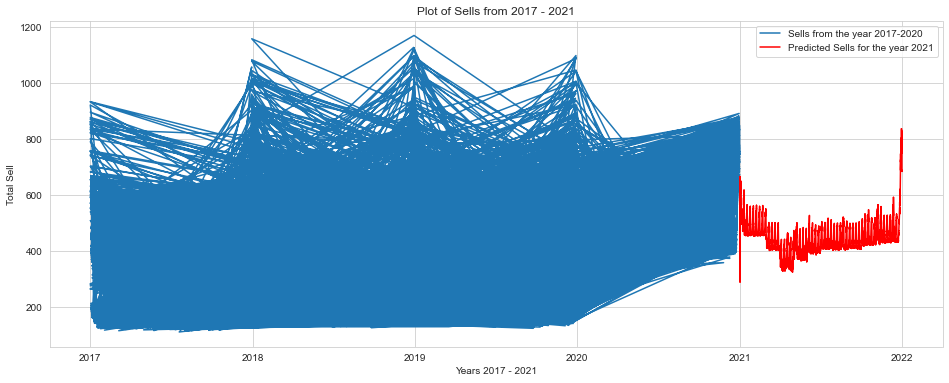

In [83]:
plt.figure(figsize=(16,6))
plt.plot(y_train.index,y_train.values,label='Sells from the year 2017-2020');
plt.plot(y_pred.index,y_pred.values,'r', label='Predicted Sells for the year 2021');
plt.title('Plot of Sells from 2017 - 2021');
plt.xlabel('Years 2017 - 2021');
plt.ylabel('Total Sell');
plt.legend();

Now it is time to make the predictions back in the format as they are required.

In [84]:
prod_seasonality = pd.DataFrame()
for p in df_test['product'].unique():
    prod_seasonality[p] = model_product_seasonality(p)

In [85]:
prod_seasonality['date'] = df_test.index.unique()
prod_seasonality = prod_seasonality.melt(id_vars=['date'])
prod_seasonality = prod_seasonality.rename(columns={'variable':'product','value':'s'})

In [86]:
df_test['T'] = y_pred['T'].values

In [87]:
submit = pd.merge(left=df_test, right= prod_seasonality, on=['date','product'], how='left')
submit = store_corrector(submit,factor=2.894)
submit['num_sold'] = submit['T']*submit['s']
submit[['row_id','num_sold']].to_csv("./submission_final.csv", index=False)

C:\Users\brieu\AppData\Local\Temp\ipykernel_11060\1026542695.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

